## 1. Finding Similar Costumers

##### In this part of the homework, we are asked to implement an algorithm that takes as input a dataset of customers and outuputs clusters of similar customers. Furthermore, we are specifically asked to use the technique called locality-sensitive hashing, or LSH, that allows us to focus on pairs that are likely to be similar, without having to look at all the features (two a the time). 

##### The difficulty of the question lies on several levels, but in particular:
- the LSH paradigm has to be applied outside the usual textbook problem of grouping together similar text documents. Here we are dealing with, let's say, `features` that can be either cathegorical or numerical. Furthermore, cathegorical features can be binomial (i.e. Gender) or multinomial (i.e. Location); numerical features can be continuous (i.e. Balance Account) or discrete (i.e. Transaction Date).
- the dataset hides complex challenges. For instance, the column `CustomerID` does NOT indetify univocally a customer. So, It may be the case that transactions with same `CustomerID` have been done by different people. Similarly, it can also be the case that different CustomerIDs are associated to the same person.

### 1.1 Set up the data

#### Preliminary set up 

In [3]:
import pandas as pd
import numpy as np

In [4]:
data = pd.read_csv('https://hw4-group6.s3.amazonaws.com/bank_transactions.csv') # import dataset from our S3 bucket

We take a look at the NA value in the dataset.

In [5]:
data.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

We fill the NA values.

In [6]:
data.dropna(inplace=True)
data.isna().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

#### Features Selection and New Index Creation

First, we have to select the features that can characterize customers.
In our opinion, `TansactionID` is not a relevant feature since it gives no information on customers but it serves just to distinguish the transactions.

In [7]:
data.drop(["TransactionID"],inplace=True,axis=1)

We then decided that `CustomerID` cannot be used as an index because it does not univocally indetify single people. 
We noticed 2 anomalies:
1. an account is associated to different people
2. a single person holds multiple bank account

In [8]:
# Example of multiple people for the same CustomerID
data[data.CustomerID == 'C3226689'] 

,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
19882,C3226689,1/1/90,M,BASTI,11369.40,26/9/16,131342,200.00
35613,C3226689,15/9/87,M,NOIDA,96820.46,30/9/16,145016,418.00
218661,C3226689,4/11/84,F,NEW DELHI,1667.83,8/8/16,190233,4700.00
756541,C3226689,17/9/72,M,SHARJAH,588826.94,1/9/16,165554,6351.39
836123,C3226689,20/7/77,M,THANE,369.36,4/9/16,134645,1749.00
984048,C3226689,21/5/85,M,GURGAON,12977.22,15/9/16,195929,1340.00


In [9]:
# Example of a single person holding different bank accounts
data[data['CustAccountBalance']== 115035495.1]

,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
40982,C2916865,3/8/67,M,SHILLONG,115035495.1,27/9/16,224912,6959.00
656264,C3316830,3/8/67,M,SHILLONG,115035495.1,28/8/16,231112,28019.32
789085,C6416825,3/8/67,M,SHILLONG,115035495.1,5/9/16,100606,5864.00
826721,C2216823,3/8/67,M,SHILLONG,115035495.1,4/9/16,141239,4699.00
835641,C2916887,3/8/67,M,SHILLONG,115035495.1,4/9/16,93141,600.00
876392,C8116818,3/8/67,M,SHILLONG,115035495.1,8/9/16,214355,3149.00
879623,C4316889,3/8/67,M,SHILLONG,115035495.1,8/9/16,213612,4364.00
1001213,C5916881,3/8/67,M,SHILLONG,115035495.1,14/9/16,160123,1599.00
1002072,C5116828,3/8/67,M,SHILLONG,115035495.1,14/9/16,151418,5060.00
1002847,C7716886,3/8/67,M,SHILLONG,115035495.1,14/9/16,153335,3604.00


##### We decided to use the fuction `fix` to assciate each person with a unique id (contextually the column `CustomerID`

In [10]:
from func.fixer import fixer
data = fixer(data)
data

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),cid
0,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0,0
1,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0,1
2,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0,2
3,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0,3
4,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5,4
...,...,...,...,...,...,...,...,...
1048562,8/4/90,M,NEW DELHI,7635.19,18/9/16,184824,799.0,101584
1048563,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.0,123224
1048564,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.0,8977
1048565,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.0,170860


### 1.2 Fingerprint hashing

The LSH approach we’re goig to implement consists of a threefold process:
1. we create sparse vectors (or one-hot vectors) using k-shingling; 
2. we use minhashing to create ‘signatures’;
3. we pass the signatures onto our LSH process to weed out candidate pairs.

![HTML page](https://miro.medium.com/max/720/1*27nQOTC79yfh5lzmL06Ieg.webp)

#### Shingling

##### The goal of this section is to build a sparse matrix of one-hot vectors. A one-hot vector is a vector of zeros and ones where the latter number indicates the presence of a particular feature (the former its absence). 
##### To ease our problem, we decided to work only with binomial features. 
##### Therefore, what follows is the creation of these binomial features.

1. The first feature is `CustGender` that assumes values of 1 if 'male' 0 if 'female'.

In [11]:
# 1. CustGender: Male -> 1, Female -> 0
data['CustGender']= np.where(data.CustGender == 'M' , 1 , 0)

2. The second, third, fourth, and fith features deals with the age of the customers. The age is extracted by converting the column `CustomerDOB` with the *to_datetime* module.
##### Then, we create features that indentify teens, young people, adults, and old people.

In [12]:
data.CustomerDOB = pd.to_datetime(data.CustomerDOB)
data.loc[data.CustomerDOB.dt.year>2000,'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100) # if the year is bigger than 2000 subtract 1000
data.drop(data[data.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True) # remove CustomerDOB values if equal to 1800

In [13]:
# 2. Teen: Yes -> 1, No -> 0
data['Teen']= np.where(data.CustomerDOB.dt.year >= 1997 , 1 , 0)

In [14]:
# 3. Young: Yes -> 1, No -> 0
data['Young']= np.where((data.CustomerDOB.dt.year < 1997) & (data.CustomerDOB.dt.year >= 1988) , 1 , 0)

In [15]:
# 4. Adult: Yes -> 1, No -> 0
data['Adult']= np.where((data.CustomerDOB.dt.year < 1988) & (data.CustomerDOB.dt.year >= 1950) , 1 , 0)

In [16]:
# 5. Old?: Yes -> 1, No -> 0
data['Old?']= np.where(data.CustomerDOB.dt.year < 1950 , 1 , 0)
data.drop(["CustomerDOB"],axis=1,inplace=True) # remove CustomerDOB column

3. The six and seven columns identify rich or poor people. Is rich the person that is ranked in the top 20% of richest people of the database; is poor the person that has less than 100 euros in his bank account.

In [17]:
# 6. Rich: Top20% -> 1
data['Rich'] = np.where(data['CustAccountBalance'] >= data['CustAccountBalance'].quantile(0.8) , 1 , 0)

In [18]:
# 7. Poor: BA < 100€ (INR = 0.01 Eur)
data['Poor'] = np.where(data['CustAccountBalance'] <= 100*100 , 1 , 0)

4. The eigth feature is about locations. We group people whether they are or not in one of the three top populated cities of India.

In [19]:
# Visualization of the most populated cities
from IPython.display import Image
from IPython.core.display import HTML 
display(Image(url='http://urbanecology.in/wp-content/uploads/2014/10/top-ten-most-populated-cities-india.png', width=500, unconfined=True))


In [20]:
# 8. Top_Populated_City?: Yes -> 1, No -> 0 
cities = ['MUMBAI','NAVI MUMBAI','NEW DELHI','DELHI','KOLKATA']
data['Top_Populated_City'] = np.where(data['CustLocation'].isin(cities),1,0)
data.drop(["CustLocation"],axis=1,inplace=True)

5. Then we may be interested in the time the transactions have happened. So we build some categorical features:
- Summer that tells wheater the transaction occured during summer
- Fall that tells wheater the transaction occured during
- Winter that tells wheater the transaction occured during
- Spring that tells wheater the transaction occured during
- Week_End that tells wheater the transaction occured during the weekend
- Morning that tells wheater the transaction occured in the morning
- Afternoon that tells wheater the transaction occured in the afternoon
- Evening that tells wheater the transaction occured in the evening
- Night that tells wheater the transaction occured in the night

To do that we extract the month, the day, and the day of the week from the transaction date. Then we extract the time of the day at which the transaction has occured

In [21]:
from datetime import datetime
tr_d = [i.split("/")[0] for i in data.TransactionDate.values]
tr_m = [i.split("/")[1] for i in data.TransactionDate.values]
tr_y = [i.split("/")[2] for i in data.TransactionDate.values]
dow = [datetime(int(tr_d[i]),int(tr_m[i]),int(tr_y[i])).strftime("%A") for i in range(len(tr_d))]
data["TransactionDay"] = tr_d
data["TransactionMonth"] = tr_m
data["TransactionDOW"] = dow

In [22]:
# 9. Summer: Yes -> 1, No -> 0
data['Summer']= np.where((data.TransactionMonth == '6')
                                  | (data.TransactionMonth == '7')
                                  | (data.TransactionMonth == '8') , 1 , 0)

In [23]:
# 10. Fall: Yes -> 1, No -> 0

data['Fall']= np.where((data.TransactionMonth == '9')
                                  | (data.TransactionMonth == '10')
                                  | (data.TransactionMonth == '11') , 1 , 0)

In [24]:
# 11. Winter: Yes -> 1, No -> 0

data['Winter']= np.where((data.TransactionMonth == '12')
                                  | (data.TransactionMonth == '1')
                                  | (data.TransactionMonth == '2') , 1 , 0)

In [25]:
# 12. Spring: Yes -> 1, No -> 0
data['Spring']= np.where((data.TransactionMonth == '3')
                                  | (data.TransactionMonth == '4')
                                  | (data.TransactionMonth == '5') , 1 , 0)

In [26]:
# 13. Start_of_Month: Yes -> 1, No -> 0
first_days = ['1','2','3','4','5','6','7']
data['Start_of_Month']= np.where(data['TransactionDay'].isin(first_days),1,0)

In [27]:
# 14. End_of_Month: Yes -> 1, No -> 0
last_days = ['25','26','27','28','29','30','31']
data['End_of_Month']= np.where(data['TransactionDay'].isin(last_days),1,0)

In [28]:
# 15. Week_End: Yes -> 1, No -> 0
data['Week_End']= np.where((data.TransactionDOW == 'Friday')
                                  | (data.TransactionDOW == 'Saturday')
                                  | (data.TransactionDOW == 'Sunday') , 1 , 0)

In [29]:
hh = [int(datetime.fromtimestamp(i).strftime("%H")) for i in data.TransactionTime.values] # extract the hour
time = []
for i in hh: # for each hour, assign a "part of the day"
    if i >=0 and i < 13:
        time.append("Morning")
    elif i >= 13 and i<=17:
        time.append("Afternoon")
    elif i > 17 and i <= 19:
        time.append("Evening")
    elif i > 19:
        time.append("Night")
        
data["TransactionTimeOfDay"] = time

In [30]:
# 16. Morning: Yes -> 1, No -> 0
data['Morning']= np.where((data.TransactionTimeOfDay == 'Morning'),1,0)

In [31]:
# 17. Afternoon: Yes -> 1, No -> 0
data["Afternoon"] = np.where((data.TransactionTimeOfDay == 'Afternoon'),1,0)

In [32]:
# 18. Evening: Yes -> 1, No -> 0
data["Evening"] = np.where((data.TransactionTimeOfDay == 'Evening'),1,0)

In [33]:
# 19. Night: Yes -> 1, No -> 0
data["Night"] = np.where((data.TransactionTimeOfDay == 'Night'),1,0)

In [34]:
data.drop(["TransactionDOW"],axis=1,inplace=True)
data.drop(["TransactionMonth"],axis=1,inplace=True)
data.drop(["TransactionDate"],axis=1,inplace=True)
data.drop(["TransactionTime"],axis=1,inplace=True)
data.drop(["TransactionDay"],axis=1,inplace=True)
data.drop(["TransactionTimeOfDay"],axis=1,inplace=True)

6. Lastly, we want to focus on the 'relative' amount of the transaction. We claim that the transaction is 'important' if it is at least 20% of the entire bank acount and it is at least 1000 euros.

In [35]:
# 20. Important_Transaction: Yes -> 1, No -> 0
data['%Transaction/Account'] = data['TransactionAmount (INR)']/data.CustAccountBalance
data['Imp_Transaction'] = np.where((data['%Transaction/Account'] >= 0.2) & (data['TransactionAmount (INR)']>=100000) , 1 , 0)
data.drop(["CustAccountBalance"],axis=1,inplace=True)
data.drop(["TransactionAmount (INR)"],axis=1,inplace=True)
data.drop(["%Transaction/Account"],axis=1,inplace=True)

Then, we set up our `cid` column as the index of the dataframe

In [36]:
column_to_move = data.pop("cid")
data.insert(0, "cid", column_to_move)
col= data.columns[1:]

After that, we want to have only one row per user. Moreover, each row must contain the most frequent realization of each feature. For instance, a user with 10 transactions is rich if he is rich in at least 5 transactions.

In [37]:
data = data.groupby(['cid'])[col].mean()
data = data.apply(np.int32)
data.columns

Index(['CustGender', 'Teen', 'Young', 'Adult', 'Old?', 'Rich', 'Poor',
       'Top_Populated_City', 'Summer', 'Fall', 'Winter', 'Spring',
       'Start_of_Month', 'End_of_Month', 'Week_End', 'Morning', 'Afternoon',
       'Evening', 'Night', 'Imp_Transaction'],
      dtype='object')

### Minhashing

##### `Minhashing` is the process that allows to convert all the one-hot vectors in dense vectors (containing the so-called signatures).

##### First, we rename our columns:

In [38]:
data.columns = [x for x in range (0,20)]
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
cid,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,1,1,1,0,0,0,1,0,1,1,0,0,0,0


We define `minhash` function that returns the number of the column, in the list of the permuted columns, in which the row has a 1.

In [39]:
def minhash(sparse_matrix,hashefuncs):
    
    """
        Args:
            - sparse_matrix (pandas DataFrame): matrix of one-hot vectors (# customers x # hash functions)
            - hashefuncs (list): list of column names
            
        Returns:
            - signature (pandas DataFrame): sort of signature matrix (# customers x # hash functions)
    """
    
    import random
    j = sparse_matrix.copy() # make a copy of the original data
    signature = pd.DataFrame(index=j.index,columns=hashefuncs) # initialize the signature matrix
    cols = signature.columns  
    n_hash = len(cols)
    for k in range(1,n_hash+1):
        new_cols = list(j.columns)
        random.Random(4).shuffle(new_cols) # permute columns
        j.columns = new_cols # these permuted columns are the new columns
        x = j[sorted(j.columns)].idxmax(axis=1) # for each row, take the column number in which there is the first 1
        signature[cols[k-1]] = x #assign the above result to the k-1 column of signature
    del(j)  # delete j
    return signature

We apply the above function to our data:

In [40]:
signature = minhash(data,[f'h{x}' for x in range(0,20)])
signature

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19
cid,,,,,,,,,,,,,,,,,,,,
0,10,6,16,12,13,1,19,7,11,0,17,3,14,2,10,6,16,12,13,1
1,14,2,10,1,10,6,11,0,13,1,11,0,10,0,14,2,10,1,10,6
2,10,0,16,3,13,1,10,6,11,0,13,1,14,2,10,0,16,3,13,1
3,11,0,8,3,5,2,9,1,4,5,11,0,8,3,5,0,9,3,4,2
4,2,0,6,1,8,0,1,0,7,0,0,1,3,2,2,0,5,1,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170856,2,3,5,2,5,1,1,5,4,0,0,3,3,0,2,3,4,2,4,1
170857,2,2,5,2,5,6,1,1,4,1,0,0,3,0,2,2,4,2,4,5
170858,2,0,5,3,9,1,1,5,7,0,0,1,3,2,2,0,4,3,12,1


Notice that this is not the final usual signature matrix, but it is a intermediate output.

Then, we define `create_suvectors` function that divides the `signature` dataframe in `b` equal parts of wideness `r`.
We divide the dataset because we do not want to compute the Jaccard Similarity on the whole dataset, element by element. However, we want to group the clients according to a similarity semantic.
Thus we divide the columns in `b` parts and we follow the following rule:
> Two customers are considered candidate pairs (meaning they have the possibility to have a similarity score above the desired threshold), if the two customers have at least one signature in common.

But what value of be are we supposed to choose?
We use the function `tune` that plot the relation between the true Jaccard Similarity (on the x axis) and the probability of similarity (on the y axis), probability that comes from the procedure. we are implementing.  

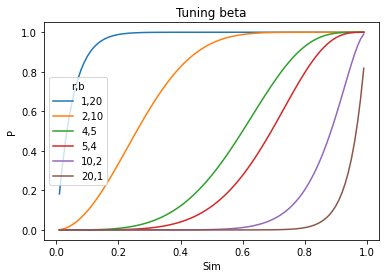

In [41]:
import func.tune
func.tune.tune()

According to the picture above, the best choices (in the sense that they balance the trade-off btw false positives and false negatives) are `b = 4` or `b = 5`.
That's because, the higher `b`, the higher the possibility to have signatures in common among customers.

##### We decide to opt for `b = 4`, the true reason of this choice will be explained later...

For the moment, we define the function `create_subvectors` that given `b`, number of bands, divides the matrix in `b` subvectors of `r` number of columns, where `r` is the ratio between the number of hashfunctions and `b`.

In [42]:
def create_subvectors(signature,b):
    
    """
        Args:
            - sparse_matrix (pandas DataFrame): matrix of one-hot vectors (# customers x # hash functions)
            - b (int and divisor of number of hashfunctions): number of bands
            
        Returns:
            - subvec (list of dataframes): b subvectors
    """
    
    k = len(signature.columns)
    assert k % b == 0 # verify if k is divisible by b
    r = int(k / b)
    subvecs = []
    for i in range(0, k, r):
        subvec = pd.DataFrame(signature.iloc[:,i:i+r]) # cut the matix in b subvectors
        subvecs.append(subvec)
        
    return (subvecs)

In [43]:
# example of subvectors with b=4
b = 4
subvecs = create_subvectors(signature,b)
for sub in subvecs:  
    print(sub.head(3),'\n\n') 

     h0  h1  h2  h3  h4
cid                    
0    10   6  16  12  13
1    14   2  10   1  10
2    10   0  16   3  13 


     h5  h6  h7  h8  h9
cid                    
0     1  19   7  11   0
1     6  11   0  13   1
2     1  10   6  11   0 


     h10  h11  h12  h13  h14
cid                         
0     17    3   14    2   10
1     11    0   10    0   14
2     13    1   14    2   10 


     h15  h16  h17  h18  h19
cid                         
0      6   16   12   13    1
1      2   10    1   10    6
2      0   16    3   13    1 




The `sig` function follows. It transforms the list of subvectors before created in a matrix contained `b` signatures for each customer.

In [44]:
def sig(subvecs):
    
    '''
        Args: 
            - subvecs (list of dataframes)
        Returns:
            - df (datframe)
    '''
    df = pd.DataFrame(index=subvecs[0].index.copy())
    for i in range(len(subvecs)):
        sigvec = pd.DataFrame(index=subvecs[0].index.copy())
        sigvec[f'signature{i+1}'] = subvecs[i].astype(str).values.sum(axis=1)
        df = pd.merge(left=df, right=sigvec, how='left', left_on='cid', right_on='cid')
    return df

To test the correctness of the code, we print the 4th row of the subvectors.

In [45]:
sig_table = sig(subvecs)
sig_table.iloc[4,]

signature1    20618
signature2    01070
signature3    01322
signature4    05190
Name: 4, dtype: object

We expect to see '20618', '01070', '01322', and '05190'.

In [46]:
# TEST
for sub in subvecs:  
    print(sub.iloc[4,],'\n\n') 

h0    2
h1    0
h2    6
h3    1
h4    8
Name: 4, dtype: int64 


h5    0
h6    1
h7    0
h8    7
h9    0
Name: 4, dtype: int64 


h10    0
h11    1
h12    3
h13    2
h14    2
Name: 4, dtype: int64 


h15    0
h16    5
h17    1
h18    9
h19    0
Name: 4, dtype: int64 




Finally, the function `hash_bucket` groups the customers according to their signatures.

In [47]:
# Create Hash table

'''
    Args:
        - sig_table (dataframe): table of signatures
    Returns:
        - buckets (dataframe) : table of buckets
'''

def hash_bucket(sig_table):
    sig_table = sig_table.reset_index()
    buckets = sig_table.groupby([f'signature{i+1}' for i in range(0,b)]).agg({'cid':lambda x: list(x)}) # for each row, group by signatures the customers 
    buckets =  buckets.sort_index(ascending=True) # order by signatures
    return buckets


In [48]:
buckets = hash_bucket(sig_table)
buckets.head(10)

cid
signature1 signature2 signature3 signature4                                                   
100117     00030      216010     01170                            [60459, 67846, 74955, 93857]
           10030      216010     01171       [8661, 21225, 25038, 39073, 52431, 83433, 8694...
                      216210     01171                  [24368, 38113, 114542, 117270, 124642]
100125     10630      21605      01241       [7220, 26814, 72934, 84883, 85157, 85480, 1217...
100127     00330      216010     01270                                                 [69234]
           10630      216010     01271       [17616, 58262, 66930, 85427, 99668, 110074, 11...
10013110   0100110    10110010   0131100     [29742, 32207, 33970, 34704, 35580, 36206, 366...
           1100110    13110010   0131101     [51, 81, 114, 136, 152, 198, 199, 228, 236, 25...
10013111   0100110    10110210   0131110     [6, 35869, 37878, 38664, 41715, 43075, 43586, ...
10013113   1100110    13110210   0131131     [240, 393, 432, 496, 653, 688, 735, 1086, 1191...

Notice that the output is a multindexed dataframe. Customers are grouped primarely by the fist signature, then by the second, and so on. If the first signature is common to two customers, they are placed together. After the first signature, the second is evaluated. If all the signatures are equal, the customers are identical (at least w.r.t. the features here created).
Notice also that the customers are ordered by ascending signatures. Thus, customers that are grouped in separate but close buckets are likely to show high a similarity.

#### Potential problem
The choice of `b = 4` is not random. Looking again at the graph in the beginning of the `Minhashing` part, we should have prefered `b = 5` over `b = 4`.
However, imagine to have chosen `b = 5` and to have had two bucket that group customers having:
- very different first and second signatures;
- equal third, fourth, and fith signatures.

In this case, by looking at the table we would incorrectly argue that the buckets grouped dissimilar people.
Therefore, since we want our buckets to be proximity-sensitive, we have to choose `b = 4` over `b = 5`.

In [49]:
# TEST the Jaccard Similarity of the customers found in the top adjacent buckets
import func.jaccard_sim
bucket = [137650,137615,6067,15156,135122,140265,138056,144845] 
print(func.jaccard_sim.Jsim(bucket,data))

     cust1   cust2  similarity
0   137650  137615    0.875000
1   137650    6067    0.666667
2   137650   15156    0.555556
3   137650  135122    0.875000
4   137650  140265    0.750000
5   137650  138056    0.777778
6   137650  144845    0.777778
7   137615    6067    0.555556
8   137615   15156    0.625000
9   137615  135122    0.750000
10  137615  140265    0.857143
11  137615  138056    0.666667
12  137615  144845    0.666667
13    6067   15156    0.857143
14    6067  135122    0.750000
15    6067  140265    0.625000
16    6067  138056    0.500000
17    6067  144845    0.500000
18   15156  135122    0.625000
19   15156  140265    0.714286
20   15156  138056    0.400000
21   15156  144845    0.400000
22  135122  140265    0.857143
23  135122  138056    0.666667
24  135122  144845    0.666667
25  140265  138056    0.555556
26  140265  144845    0.555556
27  138056  144845    0.777778


In [50]:
# TEST: given a customer on the top bucket, compare with bottom buckets customers
top_cust = 137650
bucket = [4077,392,3338,210,0]
for i in range(len(bucket)):
    list1 = [top_cust,bucket[i]]
    print(func.jaccard_sim.Jsim(list1,data))

    cust1  cust2  similarity
0  137650   4077    0.111111
    cust1  cust2  similarity
0  137650    392    0.111111
    cust1  cust2  similarity
0  137650   3338         0.0
    cust1  cust2  similarity
0  137650    210    0.111111
    cust1  cust2  similarity
0  137650      0       0.125


In [51]:
buckets.tail(5)

,,,,cid
signature1,signature2,signature3,signature4,
934110,18050,924010,38151,"[26567, 27739, 46921, 69965, 75793, 103779, 10..."
934210,18450,934010,38251,"[119351, 143232, 143325, 143342, 143814]"
93425,18440,93405,38241,[132326]
964113,18050,924210,68151,"[7926, 72556, 130365]"
96445,18440,93425,68441,[62746]


## 1.3 Locality-sensitive hashing

To try our LSH procedure, we upload a preoprocessed signature table.

In [57]:
query = pd.read_pickle('support_ex1/query.pkl') # upload the preprocessed query sig_table
query.head()

,signature1,signature2,signature3,signature4
cid,,,,
QUERY0,80125,00131,20505,01240
QUERY1,71013,02060,82107,10130
QUERY2,43117,10030,22608,31171
QUERY3,12120,40121,20601,21206
QUERY4,13120,10520,23501,31201


We then concatenate `query` with `sig_table` and we perform the `has_bucket` function.
We only plot the bucket in which the customers coming from `query_user.csv` are present.

In [53]:
cluster = hash_bucket(pd.concat([query,sig_table],axis=0))
x = pd.DataFrame(data=None, columns=cluster.columns)
for y in range(0,100):
    result = cluster[cluster.cid.apply(lambda x : f'QUERY{y}' in x)]
    if len(result) > 0:
        if len(x) == 0:
            x = result
        else:
            x = pd.concat([result,x],axis=0)
x= x.sort_index(ascending=True)
x

cid
signature1 signature2 signature3 signature4                                                   
12120      40121      20601      21205       [QUERY9, 134367, 134837, 135039, 135306, 13564...
                                 21206       [QUERY3, 134698, 134779, 134836, 135139, 13529...
12720      43121      401101     25206       [QUERY23, 133946, 134102, 134131, 134153, 1341...
12760      43127      401231     25608       [QUERY6, 133987, 134285, 134328, 134534, 13454...
13120      10520      23501      31201       [QUERY4, 6087, 8544, 8986, 9305, 9627, 10534, ...
13520      13520      63501      34201       [QUERY26, 5452, 5530, 5531, 5838, 5842, 5882, ...
13610      11020      02301      35101       [QUERY8, 4324, 137129, 137150, 137233, 137257,...
20135      00330      01322      01340       [QUERY45, 29022, 32101, 32504, 44034, 151129, ...
20535      21145      00332      04342       [QUERY42, 787, 1080, 1318, 1597, 1726, 3790, 1...
21127      00330      03302      11270       [QUERY24, 30997, 32511, 32748, 33598, 33627, 3...
21226      01310      03002      12260       [QUERY39, 30376, 32856, 32914, 33652, 33886, 4...
21519      01070      02322      141110      [QUERY48, 149876, 149918, 150139, 150177, 1502...
21618      01070      02302      15190       [QUERY7, QUERY19, 28894, 29052, 29086, 29132, ...
                                 15190       [QUERY7, QUERY19, 28894, 29052, 29086, 29132, ...
22127      40131      00302      21276       [QUERY41, 47891, 77327, 78528, 78904, 79873, 7...
22226      61111      00002      22266       [QUERY14, 216, 288, 2214, 2411, 2644, 2701, 28...
22529      61171      00302      242106      [QUERY5, 358, 390, 411, 592, 754, 772, 786, 94...
22618      41071      00302      25196       [QUERY37, QUERY40, 4728, 29505, 29506, 29921, ...
                                 25196       [QUERY37, QUERY40, 4728, 29505, 29506, 29921, ...
22625      41141      00302      25245       [QUERY44, 117, 29908, 29944, 30685, 30701, 312...
22628      41171      00302      25296       [QUERY28, 29373, 29511, 29890, 31064, 31616, 3...
23525      11540      03302      34241       [QUERY34, 884, 1772, 1875, 2151, 2374, 2556, 4...
32245      84115      70033      22545       [QUERY21, 159065, 164784, 164993, 165648, 1657...
40125      00131      20605      01240       [QUERY36, 50831, 53082, 53101, 58169, 59098, 5...
401318     05090      411028     05190       [QUERY16, QUERY43, 31924, 34285, 39458, 44156,...
                                 05190       [QUERY16, QUERY43, 31924, 34285, 39458, 44156,...
40825      15640      41805      05241       [QUERY22, 30908, 32558, 33136, 33550, 33774, 3...
41117      00030      22608      11170       [QUERY10, 32174, 37479, 40693, 49143, 49356, 4...
41127      00131      20608      11270       [QUERY25, 45458, 48658, 48714, 49362, 49507, 4...
41825      05141      40805      15240       [QUERY30, QUERY31, 28948, 29763, 29985, 30286,...
                                 15240       [QUERY30, QUERY31, 28948, 29763, 29985, 30286,...
42013      42061      40107      20136                                               [QUERY11]
421028     45191      401108     25296       [QUERY12, QUERY46, 19, 185, 3438, 3576, 4734, ...
                                 25296       [QUERY12, QUERY46, 19, 185, 3438, 3576, 4734, ...
42845      45145      40835      25645       [QUERY20, 3599, 4195, 4569, 29249, 29688, 2998...
43117      10030      22608      31171       [QUERY2, 33069, 33738, 42125, 43172, 47875, 48...
45093      10730      23127      401231                                              [QUERY13]
70023      00131      20107      00230                                               [QUERY38]
71013      02060      82107      10130                                                [QUERY1]
80125      00131      20505      01240       [QUERY0, 72436, 73055, 85382, 85447, 85587, 14...
80135      20135      20535      01342       [QUERY33, 157517, 157593, 157597, 158049, 1585...
80529 

To verify the validity of the result, we import the preprocessed data query.

In [58]:
query_data = pd.read_pickle('support_ex1/data_query.pkl') # upload the preprocessed query data
query_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
cid,,,,,,,,,,,,,,,,,,,,
QUERY0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0
QUERY1,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1
QUERY2,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
QUERY3,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
QUERY4,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0


After, we claim that close customers are similar even if they are not in the same bucket. Instead, distant customer are likely to be dissimilar. To verify this claim we plot a graph showing that the similarity between the customer `QUERY9` and other customers tendetially decreases with the distance.

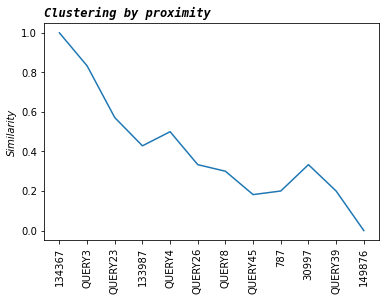

In [55]:
# Compare the customrers 'Query 9' with other customer in order of proximity
import matplotlib.pyplot as plt
data_merged = pd.concat([data,query_data],axis=0)
query9 = 'QUERY9'
bucket = [134367,'QUERY3','QUERY23',133987,'QUERY4','QUERY26','QUERY8','QUERY45',787,30997,'QUERY39',149876]
y = []
for ele in bucket:
    list1 = [query9,ele]
    x = func.jaccard_sim.Jsim(list1,data_merged).similarity 
    y.append(x)
plt.title("Clustering by proximity",fontsize='large',
    loc='left',
    fontweight='bold',
    style='italic',
    family='monospace') 
plt.ylabel('Similarity', style='italic', loc='center')
plt.xticks(rotation=90)
plt.plot(bucket, y)

Of course, this not always true. Firstly, we notice that if a client after `149876` has the last signature in common with `Query9`, the similarity is expected to increase from the current level of `0.11`.